# **Visión computacional para imágenes y video**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr. Gilberto Ochoa Ruiz**
### **Tecnológico de Monterrey**
## **Actividad 3.2 Google Colab - Algoritmos de mejoramiento de imágenes en el dominio espacial**
---

### Equipo 37

- Jorge Luis Ancheyta Segovia - A01796354
- Omar Aguilar Macedo - A01797078

# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Challenge](#challenge)
    1. [Prewitt Operator](#prewitt)
    2. [Sobel Operator](#sobel)
    3. [Laplace Operator](#laplace)
    4. [Realce](#realce)
    5. [Realce Imagen Médica](#pet)

## Importing Libraries <a class="anchor" name="libraries" ></a>

In [ ]:
!pip install Pillow==11.3.0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

## Simple Convolution <a class="anchor" name="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="/content/data/convolution.png" width="70%">


In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [ ]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [ ]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [ ]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

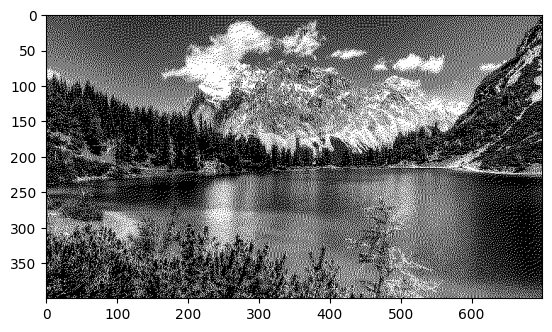

In [ ]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

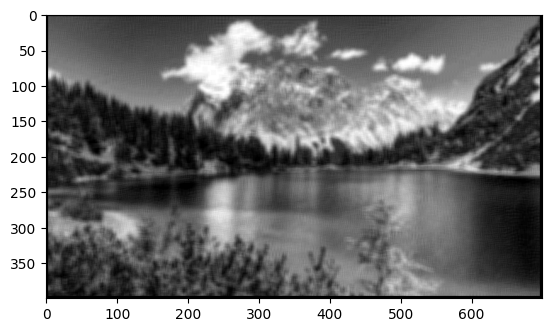

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" name="pytorch" ></a>

In [ ]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.Resampling.LANCZOS) # Resize to half to reduce the size of this notebook.

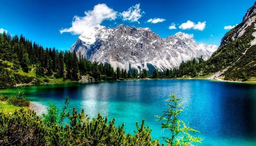

In [ ]:
img

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

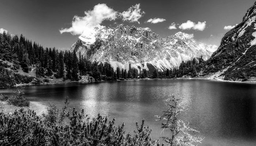

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[0.1894, 0.2911, 0.2887,  ..., 0.3962, 0.3990, 0.3020],
         [0.3145, 0.4002, 0.3967,  ..., 0.5493, 0.5051, 0.2445],
         [0.3208, 0.4118, 0.4059,  ..., 0.5437, 0.3985, 0.1767],
         ...,
         [0.1051, 0.1121, 0.1624,  ..., 0.4297, 0.4183, 0.2898],
         [0.0623, 0.1525, 0.1956,  ..., 0.4579, 0.4478, 0.3077],
         [0.0661, 0.1193, 0.0810,  ..., 0.2622, 0.2604, 0.1193]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

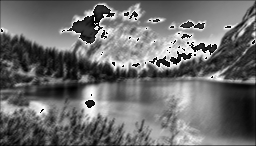

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

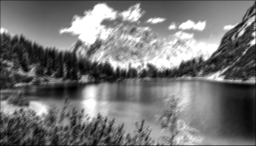

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [ ]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

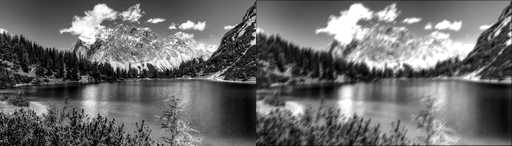

In [ ]:
display(input, output)

### Identity

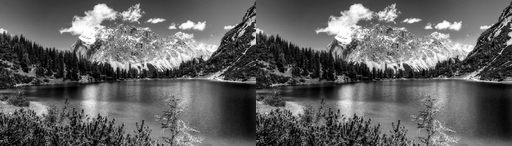

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


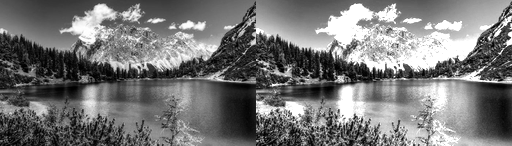

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


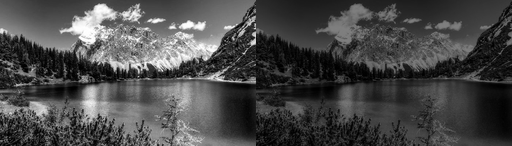

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


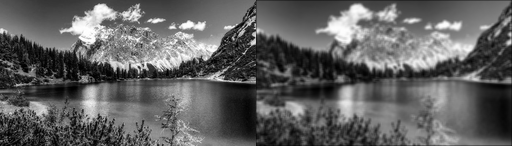

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


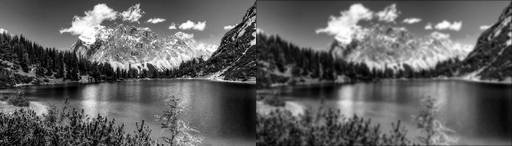

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


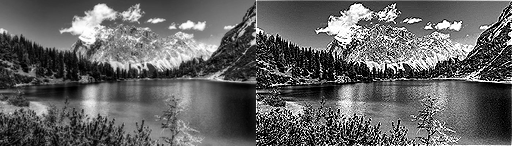

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


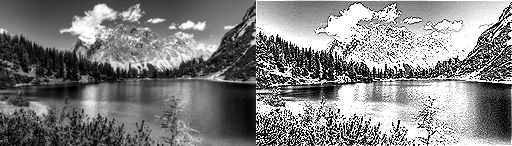

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


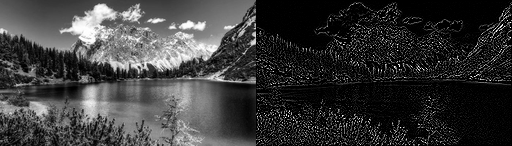

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

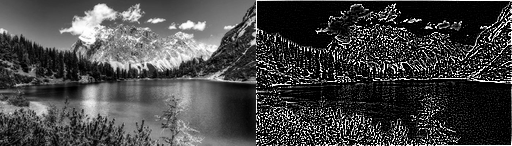

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

## Challenge <a class="anchor" name="challenge" ></a>

- Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

- Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen "máscara" (las líneas encontradas) por un factor alfa mayor a 1.

- Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes.


FIGURE 3.43 Steps
- (a) X-ray image of a circuit board, corrupted by salt-and-pepper noise.
- (b) Noise reduction using a 19 x 19 Gaussian lowpass filter kernel with s = 3.
- (c) Noise reduction using a 7 x 7 median filter.

In [ ]:
### pad test
x = np.array([
  [208., 207., 204.],
  [212., 211., 208.],
  [218., 217., 213.]
])
padded = np.pad(x, ((1, 1), (1, 1)), mode='reflect')

Tanto `Sobel` como `Prewitt`, aplican 2 kernels de tamaño fijo, uno para cada dirección, por lo que la complejidad del algoritmo  para una imagen de tamaño $N ⋅ M$ sería de $O(N ⋅ M ⋅ 2k^2)$, donde `k` es el tamaño del kernel, para ambos casos de 3 x 3.

En el caso de `Laplace`, funciona con un solo kernel por lo que su complejidad es parecida a la anterior $O(N ⋅ M ⋅ k^2)$


Dado que `k` es una constante en los 3 operadores se puede asumir que el orden final es de $O(N ⋅ M)$, ya que se tiene que procesar la imagen en su totalidad.


En cuanto a la eficacia de los operadores, si solo nos vamos por velocidad, aplicando en su totalidad cada uno de los kernels en las implementaciones hechas a mano presentadas en este documento, `Laplace` sería mas rápido ya que solo tiene que aplicarse un kernel en la imagen.

En cuanto a cual combiene más, dependerá de lo que se requiera y la imagen a procesar, por ejemplo:
- **Prewitt**: Es bueno para detectar bordes, aunque es muy sensible al ruido.
- **Sobel**: Tiene mejor detección de bordes y sensibilidad al ruido que `Prewitt`, ya que sus kernels ayudan a suavizar.
- **Laplace**: Detecta todos los cambios de intensidad, da bordes más marcados pero también es muy sensible al ruido, suele mejorar si se aplica un suavizado antes a la imagen como aplicar un filtro Gaussiano.



#### Referencias
- Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing, Global Edition (4th ed.). Pearson International Content. https://tec.vitalsource.com/books/9781292223070



In [ ]:
### Manual Operators

# Applies convolution 2d to an image, adds pad to the input
def conv2d_padding(img, kernel, mode = 'reflect'):
    kh, kw = kernel.shape
    H, W = img.shape
    pad_h, pad_w = kh // 2, kw // 2

    # apply padding, trying with different paddings from np.pad
    if mode == 'reflect':
        padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    elif mode == 'edge':
        padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    else:
        padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    out = np.empty_like(img, dtype=np.float32)

    for y in range(H):
        for x in range(W):
            patch = padded[y:y+kh, x:x+kw]
            out[y, x] = np.sum(patch * kernel)
    return out

def prewitt(img):
  Kx = np.array([[-1, 0, 1],
                 [-1, 0, 1],
                 [-1, 0, 1]], dtype=np.float32)
  Ky = np.array([[-1, -1, -1],
                 [ 0,  0,  0],
                 [ 1,  1,  1]], dtype=np.float32)

  gx = conv2d_padding(img, Kx)
  gy = conv2d_padding(img, Ky)
  mag = np.hypot(gx, gy)
  return gx, gy, mag



def sobel(img):
  Kx = np.array([[ -1,  0,  1 ],
                 [ -2,  0,  2 ],
                 [ -1,  0,  1 ]], dtype=np.float32)
  Ky = np.array([[ -1, -2, -1 ],
                 [  0,  0,  0 ],
                 [  1,  2,  1 ]], dtype=np.float32)
  gx = conv2d_padding(img, Kx)
  gy = conv2d_padding(img, Ky)
  mag = np.hypot(gx, gy)
  return gx, gy, mag


def laplace(img):
  K4 = np.array([[ 0,  1,  0],
                 [ 1, -4,  1],
                 [ 0,  1,  0]], dtype=np.float32)
  # K8 = np.array([[ 1,  1,  1],
  #                [ 1, -8,  1],
  #                [ 1,  1,  1]], dtype=np.float32)
  g4 = conv2d_padding(img, K4)
  # g8 = conv2d_padding(img, K8)

  # return None for gx, and gy, to match other outputs
  return None, None, g4



In [ ]:
### OpenCV Operator For Comparison

def prewitt_cv(img):
  Kx = np.array([[-1, 0, 1],
                 [-1, 0, 1],
                 [-1, 0, 1]], dtype=np.float32)
  Ky = np.array([[-1, -1, -1],
                 [ 0,  0,  0],
                 [ 1,  1,  1]], dtype=np.float32)

  # gx_uint8 = cv2.convertScaleAbs(grad_x)
  # gy_uint8 = cv2.convertScaleAbs(grad_y)
  # mag = cv2.addWeighted(gx_uint8, 0.5, gy_uint8, 0.5, 0)

  gx = cv2.filter2D(img, cv2.CV_32F, Kx)
  gy = cv2.filter2D(img, cv2.CV_32F, Ky)
  mag = np.hypot(gx, gy)
  return gx, gy, mag

def sobel_cv(img):
  ksize = 3
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  mag = np.hypot(gx, gy)
  return gx, gy, mag

def laplace_cv(img):
  ksize = 1
  mag = cv2.Laplacian(img, cv2.CV_32F, ksize=ksize)
  # return None for gx, and gy, to match other outputs
  return None, None, mag

In [ ]:
def plot_stats_conv2d(img, convTitle,  convFn, preProcessFn = lambda x: x, figsize=(14,6)):
  # For debugging purposes
  print(f"applying {convTitle}, img.shape {img.shape}")

  # Apply pre-process if needed
  transformed_img = preProcessFn(img)

  # Apply operator
  gx, gy, transformed_img = convFn(transformed_img)

  # Base images to plot
  images = [
      (img, 'Original'),
      (transformed_img, f'Magnitud {convTitle}')
  ];

  # Laplacian does not return gx or gy
  if gx is not None and gy is not None:
    images.append((gx, 'Gx'))
    images.append((gy, 'Gx'))

  plt.figure(figsize=figsize)

  num_plots = len(images)
  for idx, image_tuple in enumerate(images):
    image_to_plot, plt_title = image_tuple
    plt.subplot(1, num_plots, idx + 1)
    plt.title(plt_title)
    plt.imshow(image_to_plot, cmap="gray"); plt.axis("off")
  plt.show()


# Read an image in grayscale and as float32 rather than uint8
def read_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img = img.astype(np.float32)
  return img

In [ ]:
## Load a couple of images for testing
img_sudoku = read_image('data/sudoku.png')
img_face = read_image('data/62cropSBG.jpeg')
img_creature_01 = read_image('data/creature_01.jpg')
img_creature_02 = read_image('data/creature_02.jpg')

## Prewitt <a class="anchor" name="prewitt" ></a>

applying Prewitt Raw, img.shape (565, 560)


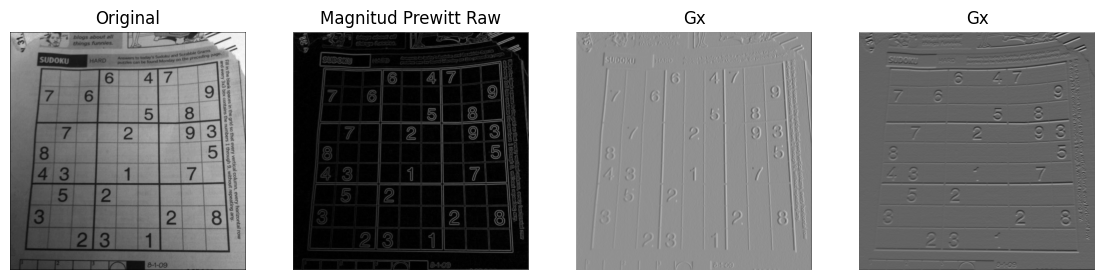

applying Prewitt With Gaus Blur (5x5), img.shape (565, 560)


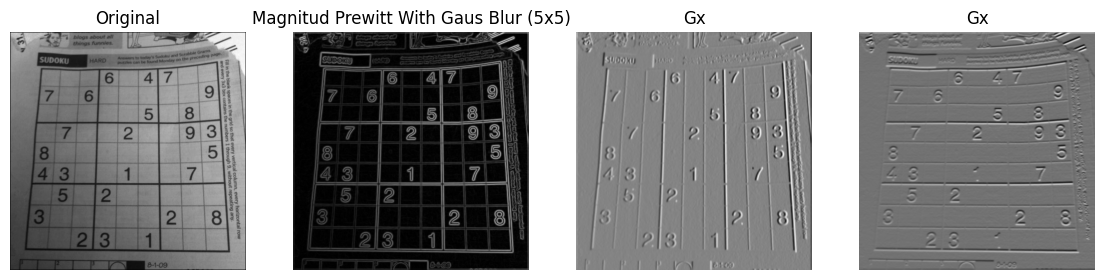

applying Prewitt With Median Blur (5), img.shape (565, 560)


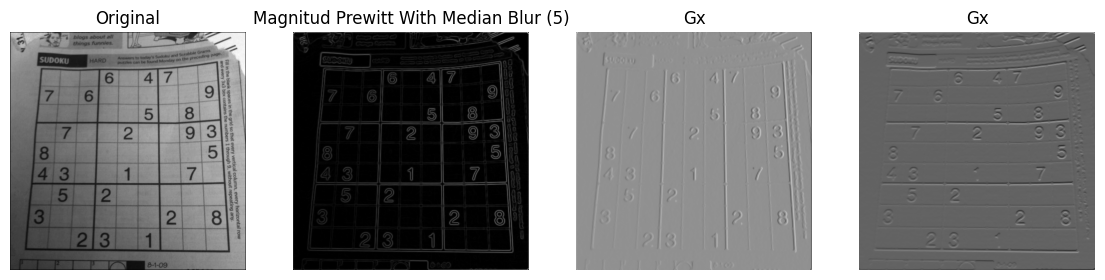

applying Prewitt With Gaus Blur (5x5), img.shape (565, 560)


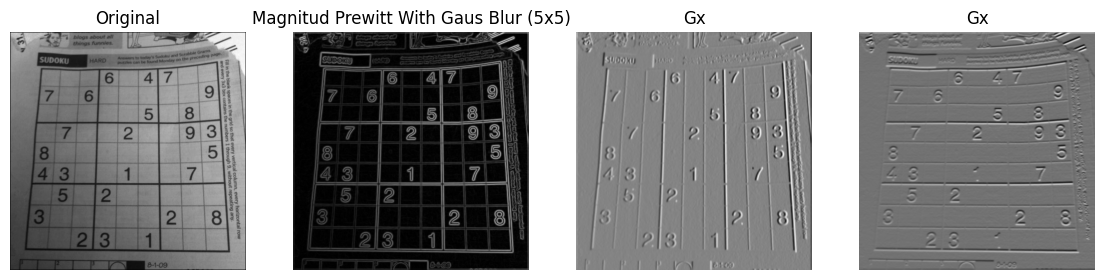

In [ ]:
img = img_sudoku

# prewitt raw no extra pre-preprocessing for the image
plot_stats_conv2d(img, 'Prewitt Raw', prewitt)

# prewitt applying a gauss filter before
plot_stats_conv2d(img, 'Prewitt With Gaus Blur (5x5)', prewitt,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

# prewitt applying a median filter before
plot_stats_conv2d(img, 'Prewitt With Median Blur (5)', prewitt,
    lambda x: cv2.medianBlur(x, 5)
)

# prewitt with opencv applying a gauss filter before
plot_stats_conv2d(img, 'Prewitt With Gaus Blur (5x5)', prewitt_cv,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)


applying Prewitt Raw, img.shape (1600, 1600)


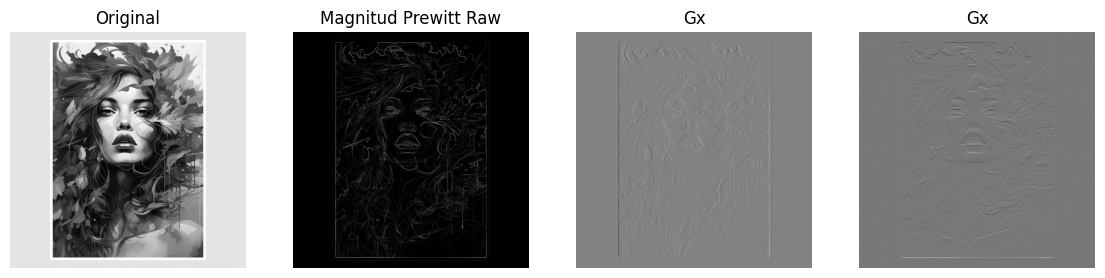

applying Prewitt With Gaus Blur (5x5), img.shape (1600, 1600)


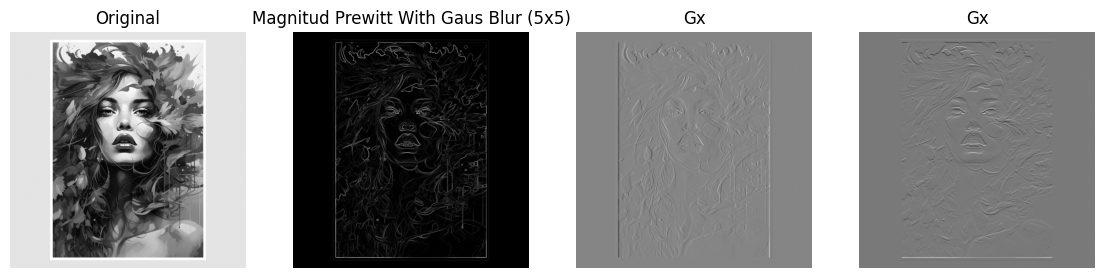

In [ ]:
img = img_face

# prewitt raw no extra pre-preprocessing for the image
plot_stats_conv2d(img, 'Prewitt Raw', prewitt)

# prewitt applying a gauss filter before
plot_stats_conv2d(img, 'Prewitt With Gaus Blur (5x5)', prewitt,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)


applying Prewitt With Gaus Blur (5x5), img.shape (959, 719)


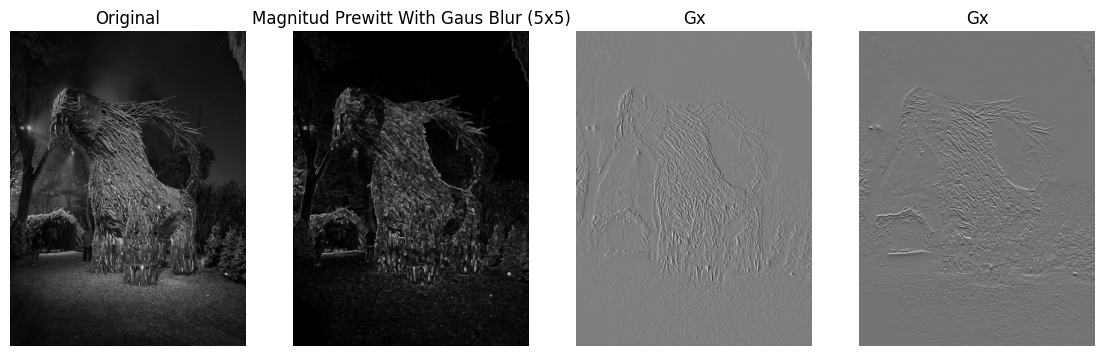

applying Prewitt With Median Blur (5), img.shape (959, 719)


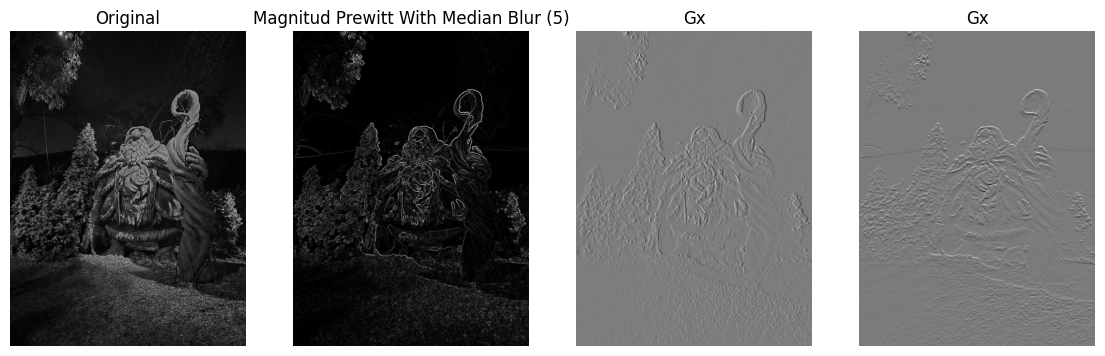

In [ ]:
img = img_creature_01
# prewitt applying a gauss filter before
plot_stats_conv2d(img, 'Prewitt With Gaus Blur (5x5)', prewitt,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

img = img_creature_02
# prewitt applying a gauss filter before
plot_stats_conv2d(img, 'Prewitt With Median Blur (5)', prewitt,
    lambda x: cv2.medianBlur(x, 5)
)

## Sobel <a class="anchor" name="sobel" ></a>


applying Sobel Raw, img.shape (565, 560)


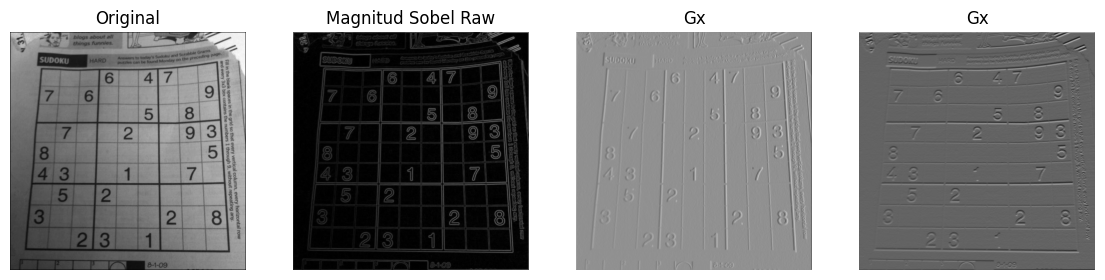

applying Sobel With Gaus Blur (5x5), img.shape (565, 560)


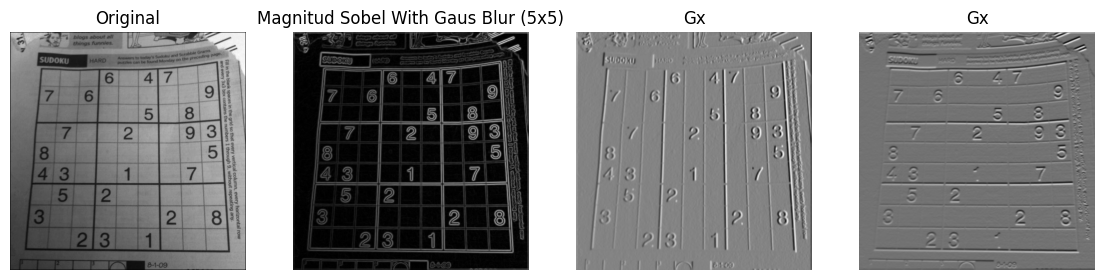

applying Sobel With Median Blur (5), img.shape (565, 560)


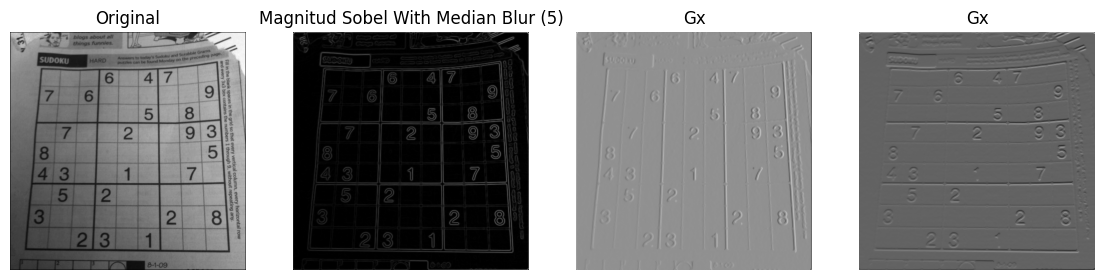

In [ ]:
img = img_sudoku

# sobel raw no extra pre-preprocessing for the image
plot_stats_conv2d(img, 'Sobel Raw', sobel)

# sobel applying a gauss filter before
plot_stats_conv2d(img, 'Sobel With Gaus Blur (5x5)', sobel,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

# sobel applying a median filter before
plot_stats_conv2d(img, 'Sobel With Median Blur (5)', sobel,
    lambda x: cv2.medianBlur(x, 5)
)

# # sobel with opencv applying a gauss filter
# plot_stats_conv2d(img, 'Sobel With Gaus Blur (5x5)', sobel_cv,
#     lambda x: cv2.GaussianBlur(x, (5, 5), 0)
# )

applying Sobel With Gaus Blur (5x5), img.shape (1600, 1600)


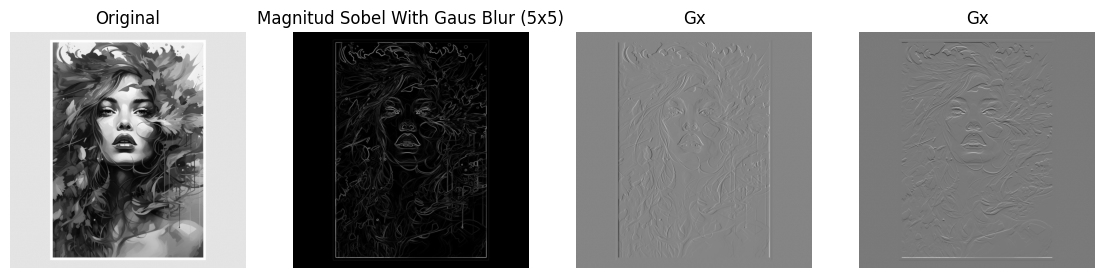

applying Sobel With Gaus Blur (5x5), img.shape (959, 719)


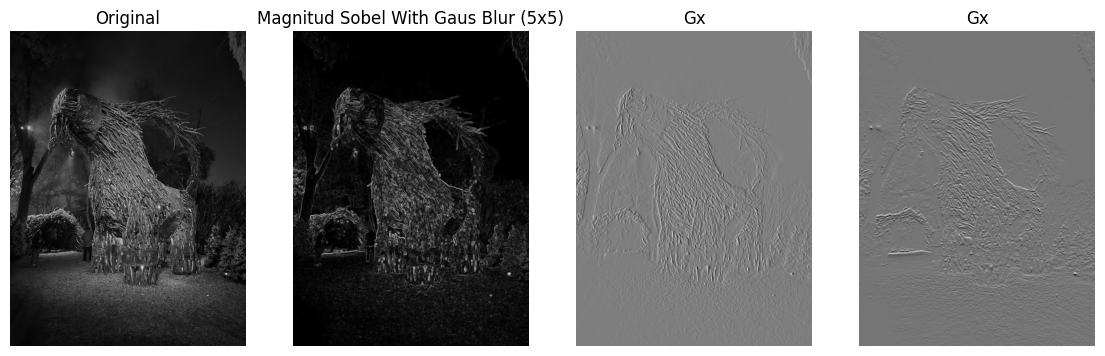

applying Sobel With Gaus Blur (5x5), img.shape (959, 719)


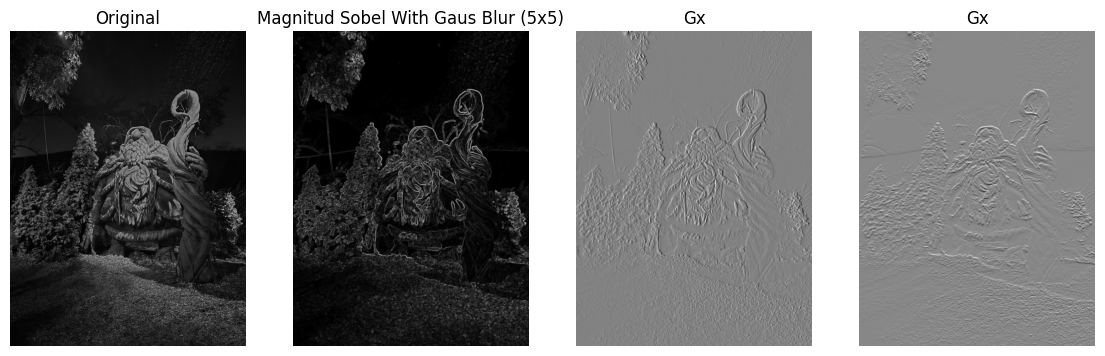

In [ ]:
plot_stats_conv2d(img_face, 'Sobel With Gaus Blur (5x5)', sobel,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

plot_stats_conv2d(img_creature_01, 'Sobel With Gaus Blur (5x5)', sobel,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

plot_stats_conv2d(img_creature_02, 'Sobel With Gaus Blur (5x5)', sobel,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0)
)

## Laplace <a class="anchor" name="laplace" ></a>

applying Laplace Raw, img.shape (565, 560)


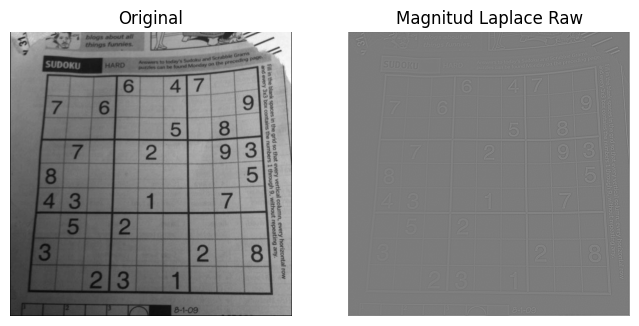

applying Laplace With Gaus Blur (5x5), img.shape (565, 560)


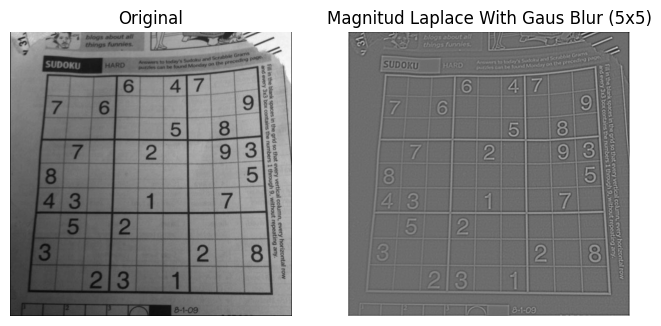

applying Laplace With Median Blur (5), img.shape (565, 560)


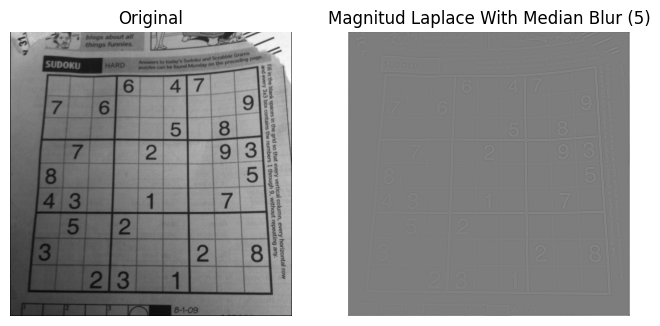

In [ ]:
img = img_sudoku
figsize=(8,4)

# laplace raw no extra pre-preprocessing for the image
plot_stats_conv2d(img, 'Laplace Raw', laplace, figsize=figsize)

# laplace applying a gauss filter before
plot_stats_conv2d(img, 'Laplace With Gaus Blur (5x5)', laplace,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0), figsize=figsize
)

# laplace applying a median filter before
plot_stats_conv2d(img, 'Laplace With Median Blur (5)', laplace,
    lambda x: cv2.medianBlur(x, 5), figsize=figsize
)

# laplace with opencv applying a gauss filter before
# plot_stats_conv2d(img, 'Laplace With Gaus Blur (5x5)', laplace_cv,
#     lambda x: cv2.GaussianBlur(x, (5, 5), 0), figsize=figsize
# )

applying Laplace With Gaus Blur (5x5), img.shape (1600, 1600)


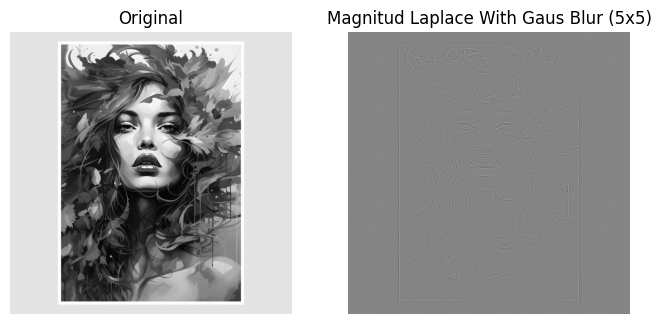

applying Laplace With Gaus Blur (5x5), img.shape (959, 719)


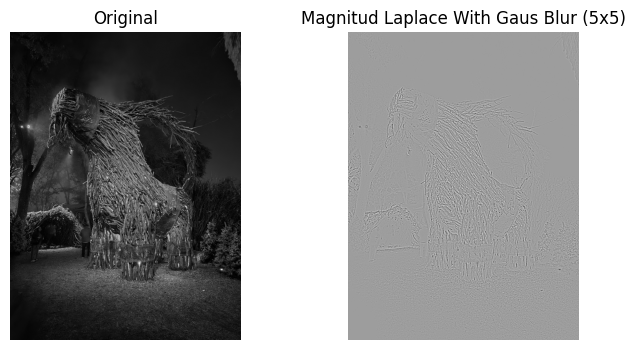

applying Laplace With Gaus Blur (5x5), img.shape (959, 719)


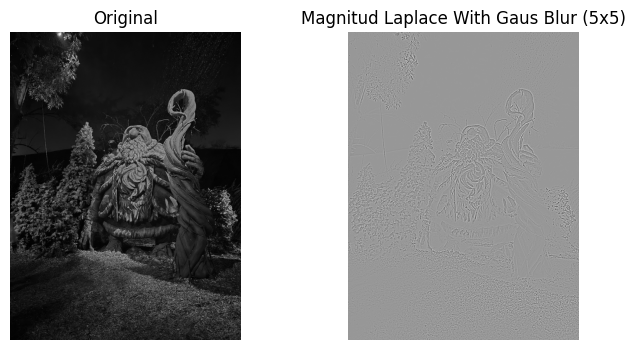

In [ ]:
plot_stats_conv2d(img_face, 'Laplace With Gaus Blur (5x5)', laplace,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0), figsize=figsize
)

plot_stats_conv2d(img_creature_01, 'Laplace With Gaus Blur (5x5)', laplace,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0), figsize=figsize
)

plot_stats_conv2d(img_creature_02, 'Laplace With Gaus Blur (5x5)', laplace,
    lambda x: cv2.GaussianBlur(x, (5, 5), 0), figsize=figsize
)

## Realce <a class="anchor" name="realce" ></a>

In [ ]:
### Unsharp Masking
def sharpen(img1, img2):
  unsharp_mask = cv2.subtract(img1, img2)
  amount = 1.5
  # sharpened_image = cv2.addWeighted(img, 1 + amount, img2, -amount, 0)
  sharpened_image = cv2.add(img1, unsharp_mask * amount)
  return sharpened_image

Same results manual vs opencv: True


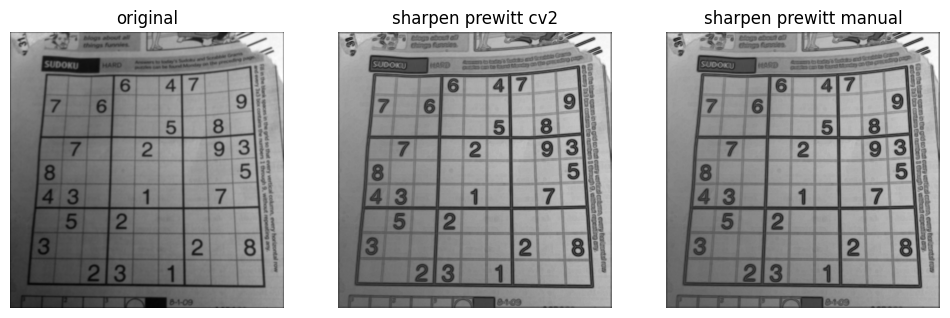

In [ ]:
# Comparativo de realce manual y opencv
img = img_sudoku
img = cv2.GaussianBlur(img, (5, 5), 0)

cv2_sharpen = sharpen(img, prewitt(img)[2])
man_sharpen = sharpen(img, prewitt_cv(img)[2])

plt.figure(figsize=(12,8))
plt.subplot(1, 3, 1); plt.title("original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("sharpen prewitt cv2"); plt.imshow(cv2_sharpen, cmap="gray"); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("sharpen prewitt manual"); plt.imshow(man_sharpen, cmap="gray"); plt.axis("off")

# validate if opencv and manual implementation produce same results
print("Same results manual vs opencv:", np.array_equal(cv2_sharpen, man_sharpen))

(np.float64(-0.5), np.float64(559.5), np.float64(564.5), np.float64(-0.5))

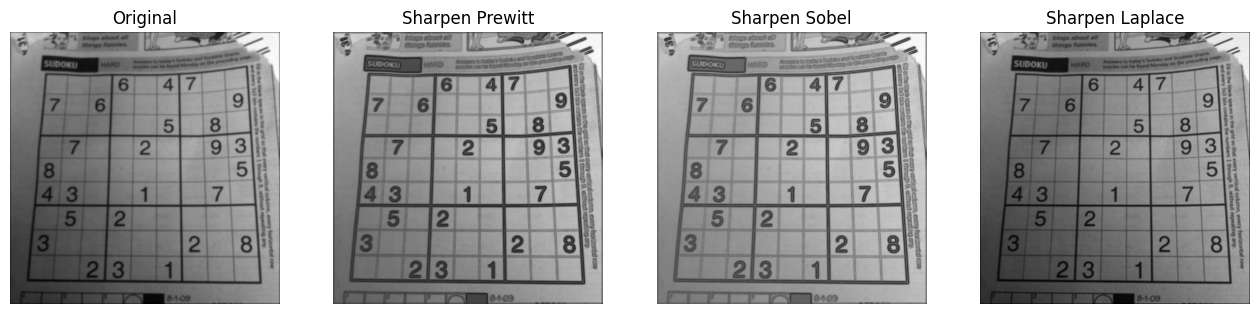

In [ ]:
# Comparativo de realce con varios operadores
img = img_sudoku
img = cv2.GaussianBlur(img, (5, 5), 0)

prewitt_sharpen = sharpen(img, prewitt_cv(img)[2])
sobel_sharpen = sharpen(img, sobel_cv(img)[2])
laplace_sharpen = sharpen(img, laplace_cv(img)[2])

plt.figure(figsize=(16,10))
plt.subplot(1, 4, 1); plt.title("Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 2); plt.title("Sharpen Prewitt"); plt.imshow(prewitt_sharpen, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 3); plt.title("Sharpen Sobel"); plt.imshow(sobel_sharpen, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 4); plt.title("Sharpen Laplace"); plt.imshow(laplace_sharpen, cmap="gray"); plt.axis("off")

(np.float64(-0.5), np.float64(1599.5), np.float64(1599.5), np.float64(-0.5))

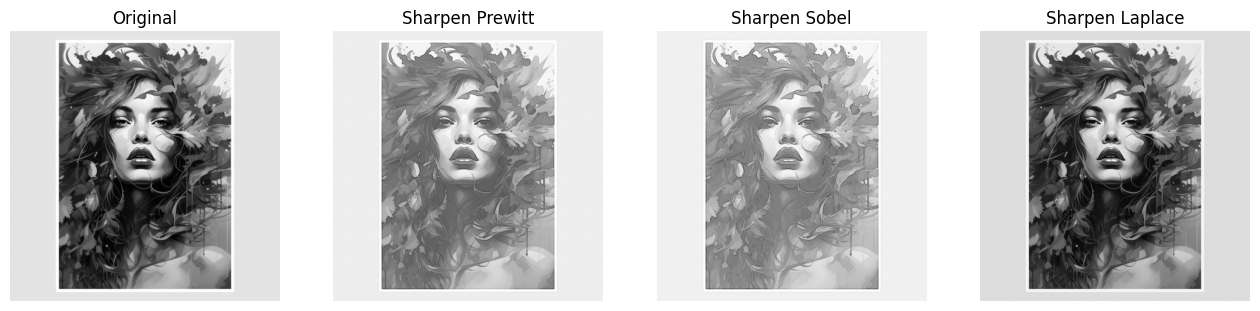

In [ ]:
img = img_face
img = cv2.GaussianBlur(img, (5, 5), 0)

prewitt_sharpen = sharpen(img, prewitt_cv(img)[2])
sobel_sharpen = sharpen(img, sobel_cv(img)[2])
laplace_sharpen = sharpen(img, laplace_cv(img)[2])

plt.figure(figsize=(16,10))
plt.subplot(1, 4, 1); plt.title("Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 2); plt.title("Sharpen Prewitt"); plt.imshow(prewitt_sharpen, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 3); plt.title("Sharpen Sobel"); plt.imshow(sobel_sharpen, cmap="gray"); plt.axis("off")
plt.subplot(1, 4, 4); plt.title("Sharpen Laplace"); plt.imshow(laplace_sharpen, cmap="gray"); plt.axis("off")

## Realce Imagen Médica <a class="anchor" name="pet" ></a>

(np.float64(-0.5), np.float64(412.5), np.float64(645.5), np.float64(-0.5))

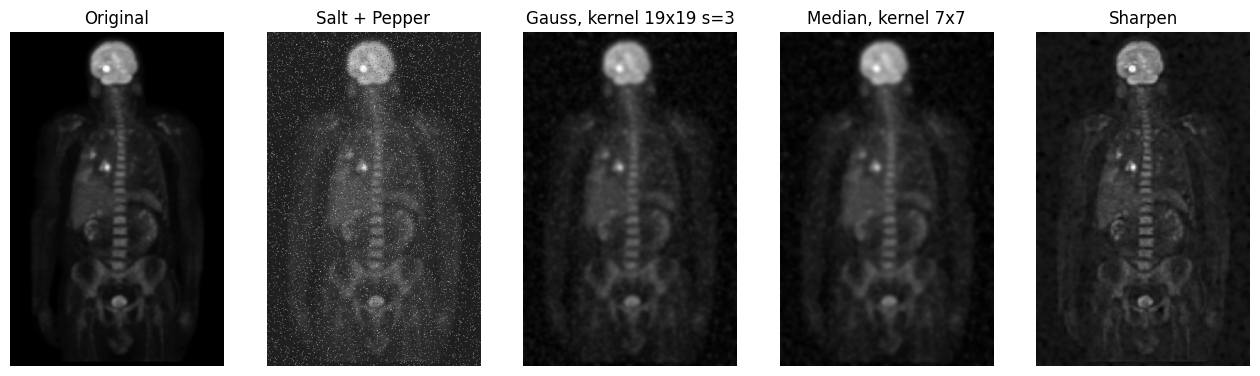

In [ ]:
# FIGURE 3.43
# (a) X-ray image of a circuit board, corrupted by salt-and-pepper noise.
# (b) Noise reduction using a 19 x 19 Gaussian lowpass filter kernel with s = 3.
# (c) Noise reduction using a 7 x 7 median filter.

def add_salt_peper_noise(imag):
  noisy = img.copy()
  # 5% of pixels with noise
  prob = 0.05
  rnd = np.random.rand(*img.shape)
  noisy[rnd < (prob / 2)] = 0       # pimienta (negro)
  noisy[rnd > 1 - (prob / 2)] = 255 # sal (blanco)
  return noisy

img = cv2.imread('data/full_body_pet.png', cv2.IMREAD_GRAYSCALE)

img_salt_pepper = add_salt_peper_noise(img)
img_gauss = cv2.GaussianBlur(img_salt_pepper, (19, 19), 3)
img_median = cv2.medianBlur(img_gauss, 7)
img_sharpen = sharpen(img.astype(np.float32), img_median.astype(np.float32))


plt.figure(figsize=(16,10))
plt.subplot(1, 5, 1); plt.title("Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1, 5, 2); plt.title("Salt + Pepper"); plt.imshow(img_salt_pepper, cmap="gray"); plt.axis("off")
plt.subplot(1, 5, 3); plt.title("Gauss, kernel 19x19 s=3"); plt.imshow(img_gauss, cmap="gray"); plt.axis("off")
plt.subplot(1, 5, 4); plt.title("Median, kernel 7x7"); plt.imshow(img_median, cmap="gray"); plt.axis("off")
plt.subplot(1, 5, 5); plt.title("Sharpen"); plt.imshow(img_sharpen, cmap="gray"); plt.axis("off")


## Conclusiones <a class="anchor" name="conclusiones" ></a>

Esta actividad nos sirvió para poder aplicar diferentes operadores sobre imagenes para detectar bordes.

Pudimos ver que la implementación de los operadores `Laplace`, `Prewitt` y `Sobel`, siguen el mismo principio, pero obtienen resultados diferentes, pudimos observar que en algunos casos a simple vista `Prewitt` y `Sobel` producen resultados similares, pero al aplicar un algoritmo para mejorar la imagen con ayuda de estos bordes podemos ver un poco mejor las diferencias, donde `Sobel` suele producir mejores resultados (aunque esto puede ser subjetivo)

El operador de Laplace por su lado es bueno pero tiene mucha sensibilidad al ruido, en imagenes simples como un sudoku tiene muy buenos resultados al realzar la imagen, sobretodo cuando la imagen se le aplica un preprocesamiento como un filtro gaussiano.

También pudimos entender como aplicar un algoritmo de realce a las imagenes, en la cual primero obtenemos una imagen mas suavizada (en el caso de la imagen PET) o solo los bordes y despues la aplicamos a la imagen original para obtener una mejor visualización de la imagen.

